# Final project of Scientific computation course
## Using California Housing DataSet
#### by Mojtaba Zolfaghari
##### STD_ID: 95143017

### Import all libraries

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

##### Turn on xkcd sketch-style drawing mode. This will only have effect on things drawn after this function is called. For best results, the "Humor Sans" font should be installed: it is not included with matplotlib.

In [71]:
plt.xkcd()
plt.show()

### Preprocessing and preparing the data

In [3]:
def preprocessing(data):

    # Extract input (X) and output (y) data from the datase

    X = data.iloc[:, :-1].values
    y = data.iloc[:, [-1]].values

    # Handle missing values: 
            # Fill the missing values with the mean of the respective column

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X[:, :-1] = imputer.fit_transform(X[:, :-1])
    y = imputer.fit_transform(y)

    # Encode categorical data: 
        # Convert categorical column in the dataset to numerical data

    from sklearn.preprocessing import LabelEncoder
    X_labelencoder = LabelEncoder()
    X[:, -1] = X_labelencoder.fit_transform(X[:, -1])

    return X, y

### Plot learning curve

In [4]:
def plot_learning_curve(model,X_train,y_train, X_val, y_val, test_size=0.2, step_length = 100):

    train_err, val_err = [], []
    for m in range(1, len(X_train), step_length):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_err.append(mean_squared_error(y_train[:m], y_train_predict))
        val_err.append(mean_squared_error(y_val, y_val_predict))
    
    plt.plot(np.sqrt(train_err), "r-+", label="Training")
    plt.plot(np.sqrt(train_err), "b-", label="Validation")
    plt.legend(loc="upper right")
    plt.xlabel("Size of the training set")
    plt.ylabel("RMSE")
    plt.show()


### Execute model hyperparameter tuning and crossvalidation

In [5]:
def model(pipeline, parameters, X_train, y_train, X, y):
    
    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)

    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)

    print("##### Results")
    print(results_sorted)

    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)

    '''Cross Validation'''

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,
                    shuffle=True,
                    random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.ravel(),
                                cv=shuffle,
                                scoring='r2')
    print("##### CV Results")
    print("mean_score", cv_scores.mean())

    '''Show model coefficients or feature importances'''

    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")

    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

    '''Predict along CV and plot y vs. y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)

    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
             xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    plt.annotate(grid_obj.best_params_, size=9,
                 xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('Predicted prices (EUR) vs. True prices (EUR)')
    plt.show()

#### Load the data Read the “housing.csv” file from the folder into the program

In [6]:
data = pd.read_csv('housing.csv')

#### Print 10 random rows of this data

In [74]:
data.sample(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
19481    -120.97     37.66                  21         2760           632.0   
19047    -121.83     38.45                  15         5115           776.0   
8341     -118.32     33.93                  37         2379           462.0   
6614     -118.10     34.17                  46         1774           315.0   
7691     -118.11     33.95                  34         2319           334.0   
7007     -118.07     33.98                  41         1478           273.0   
20469    -118.73     34.27                  23         4550           762.0   
15417    -117.27     33.21                   5         5764           996.0   
9178     -118.53     34.37                   8         3839           852.0   
6982     -118.01     33.96                  36         1805           288.0   

       population  households  median_income ocean_proximity  \
19481        1260         576         2.0227          INLAND   
19047        2540         794         4.8611          INLAND   
8341         1327         445         4.2500       <1H OCEAN   
6614          753         330         4.7241          INLAND   
7691          941         356         6.4319       <1H OCEAN   
7007          916         281         3.9688       <1H OCEAN   
20469        2301         744         4.5560       <1H OCEAN   
15417        3161        1012         4.4531       <1H OCEAN   
9178         1342         593         3.9118       <1H OCEAN   
6982          882         308         5.3054       <1H OCEAN   

       median_house_value  
19481              179800  
19047              146400  
8341               172100  
6614               279600  
7691               452300  
7007               169800  
20469              205300  
15417              177500  
9178               333700  
6982               273500

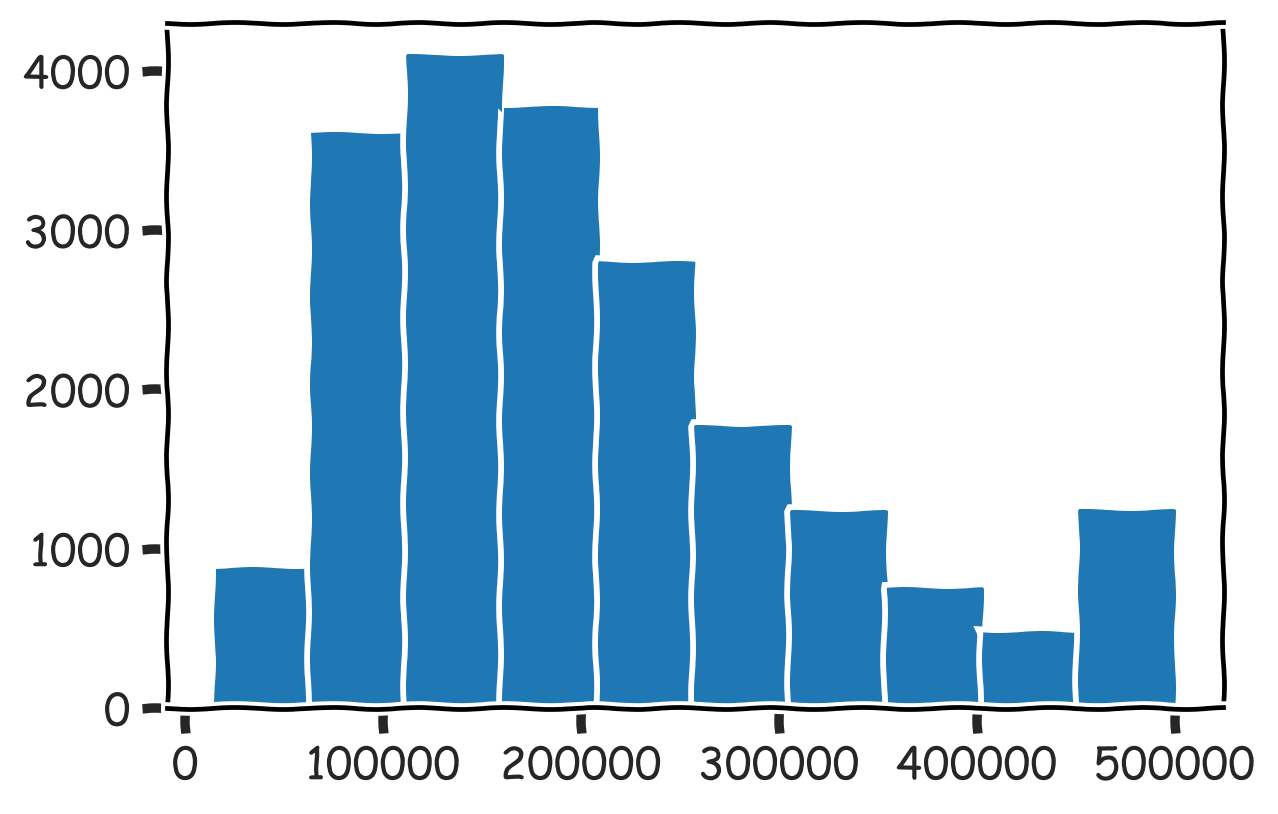

In [62]:
plt.hist((data.median_house_value))
plt.show()

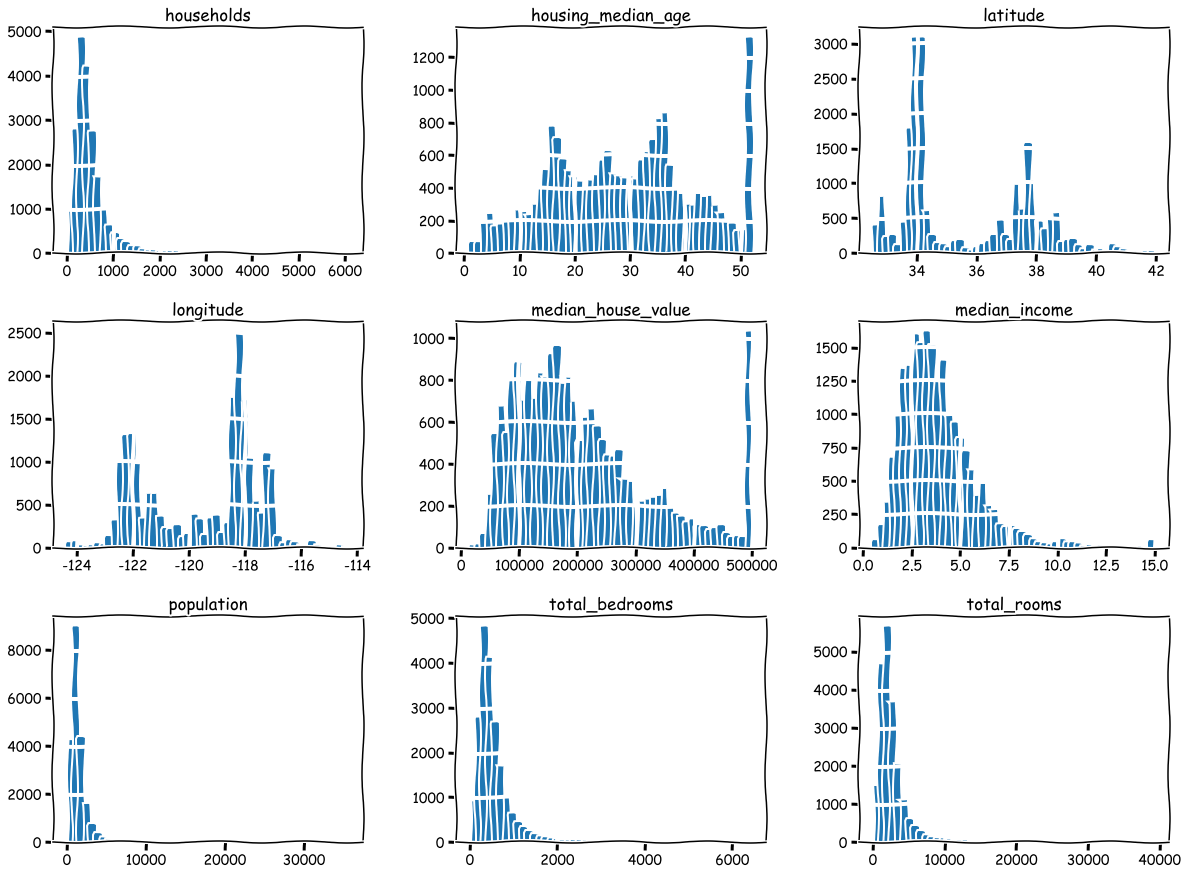

In [9]:
data.hist(bins=50, figsize=(20, 15))
plt.show()

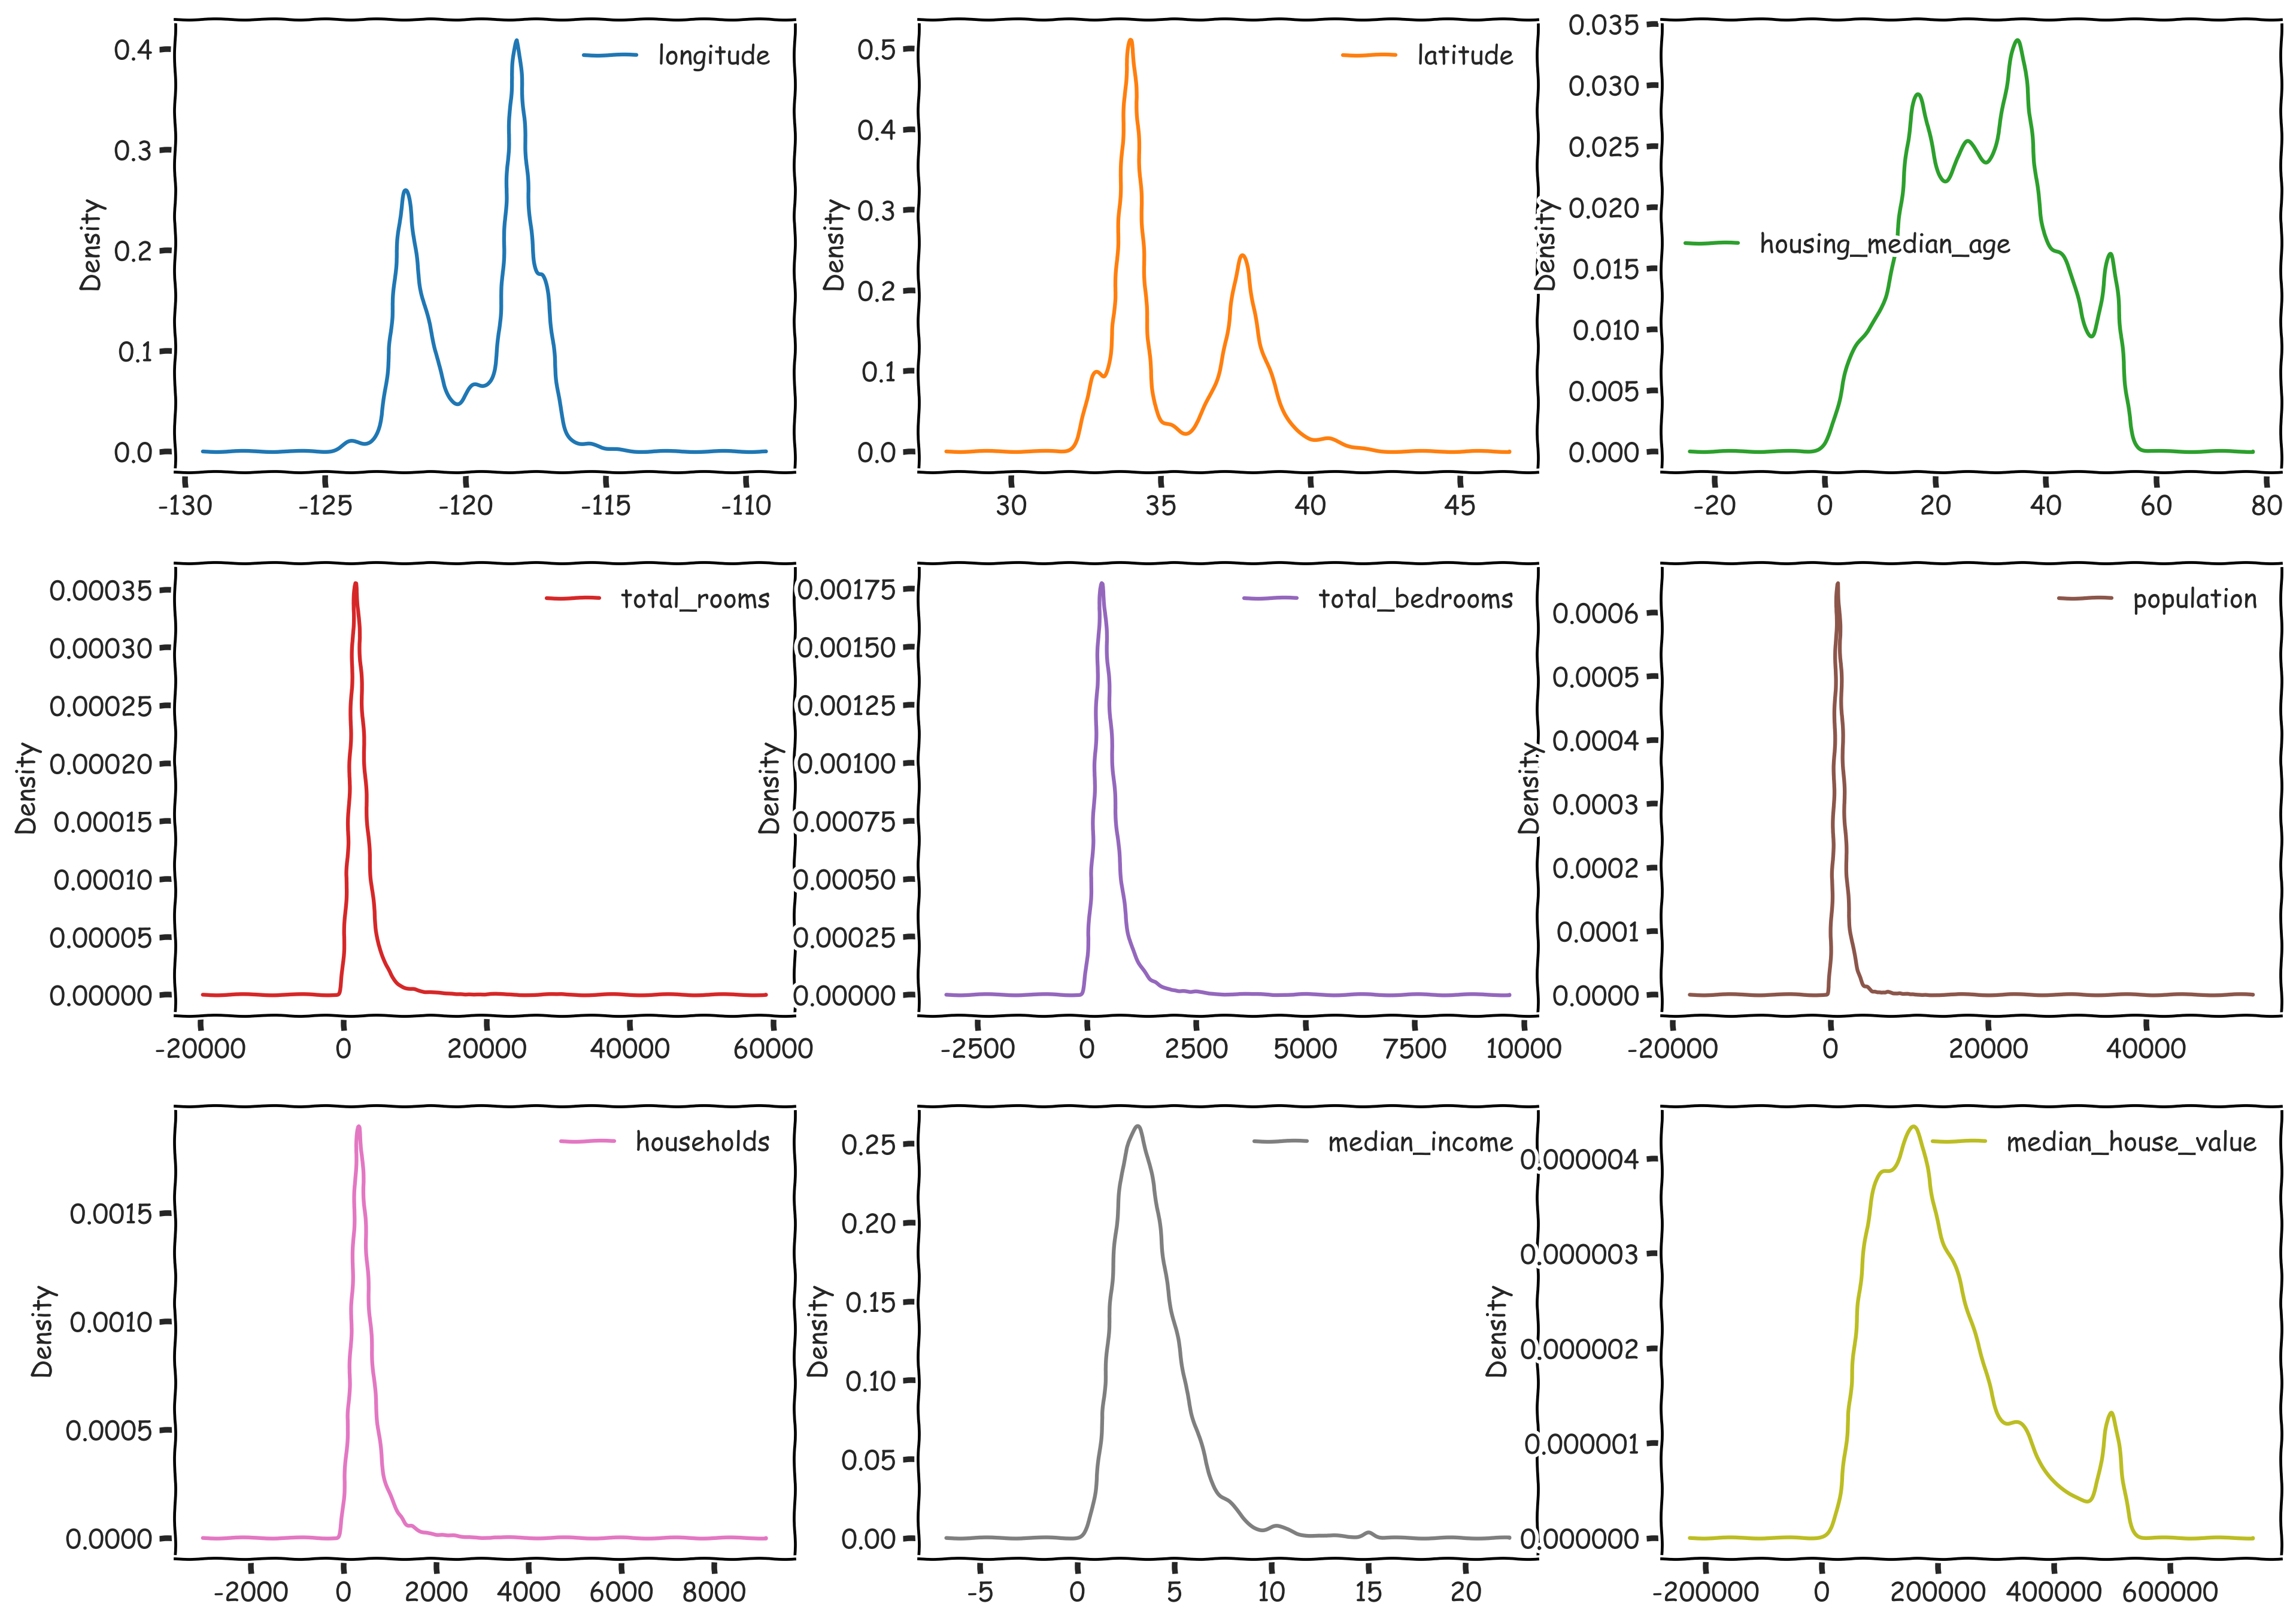

In [61]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20,15))
plt.show()

#### Execute preprocessing

In [11]:
X, y = preprocessing(data)

#### Generate polynomial and interaction features.

In [12]:
poly_features = PolynomialFeatures(degree = 3, include_bias=False)
X_poly = poly_features.fit_transform(X)

#### Split the dataset: Split the data into 80% training dataset and 20% test dataset

In [13]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_poly, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

#### Standardize data: Standardize training and test datasets

In [14]:
scaler = StandardScaler()
Xp_train = scaler.fit_transform(Xp_train)
Xp_test = scaler.transform(Xp_test)
yp_train = scaler.fit_transform(yp_train)
yp_test = scaler.transform(yp_test)

## Building and testing model with different types of Regressors

### 1) KNeighborsRegressor 

In [15]:
knn = KNeighborsRegressor(n_neighbors=1)

##### KNeighborsRegressor learning curve

##### Pipeline and Parameters for  KNN and  Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=5 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... clf__n_neighbors=5, total=  19.8s
[CV] clf__n_neighbors=5 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s


[CV] ............................... clf__n_neighbors=5, total=  19.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=  21.8s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=  24.5s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=  21.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=  25.0s
[CV] clf__n_neighbors=15 .............................................
[CV] .............................. clf__n_neighbors=15, total=  26.6s
[CV] clf__n_neighbors=15 .............................................
[CV] .............................. clf__n_neighbors=15, total=  25.5s
[CV] clf__n_neighbors=15 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.6min finished


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       2.574022      0.029854        20.929920        1.766844   
2       2.461623      0.094387        24.060648        0.892546   
3       2.493964      0.037535        27.390930        1.717003   
4       2.525304      0.034267        28.648943        0.936557   
0       2.708140      0.111552        17.475383        1.138711   

  param_clf__n_neighbors                    params  split0_test_score  \
1                     10  {'clf__n_neighbors': 10}           0.715061   
2                     15  {'clf__n_neighbors': 15}           0.713761   
3                     25  {'clf__n_neighbors': 25}           0.707006   
4                     30  {'clf__n_neighbors': 30}           0.702989   
0                      5   {'clf__n_neighbors': 5}           0.704430   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
1           0.705004           0.714313         0.711460        0.00

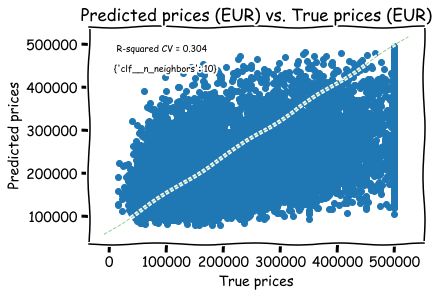

In [16]:
pipe_knn = Pipeline([('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

model(pipe_knn, param_knn, Xp_train, yp_train, X, y)

### 2) SGDRegressor

In [17]:
sgd = SGDRegressor()

#### Learning curve for SGDRegressor

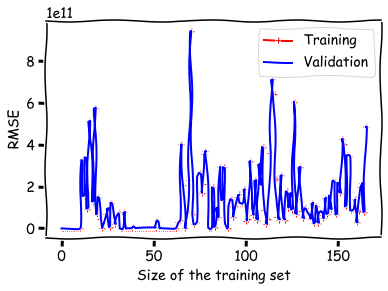

In [18]:
plot_learning_curve(sgd,
                    Xp_train,
                    yp_train.ravel(),
                    Xp_test,
                    yp_test.ravel(),
                    test_size=0.2,
                    step_length = 100)

##### Pipeline and Parameters for  SGDRegressor and  Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__alpha=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ clf__alpha=0.0001, total=   0.2s
[CV] clf__alpha=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................ clf__alpha=0.0001, total=   0.2s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=   0.2s
[CV] clf__alpha=1e-05 ................................................
[CV] ................................. clf__alpha=1e-05, total=   0.4s
[CV] clf__alpha=1e-05 ................................................
[CV] ................................. clf__alpha=1e-05, total=   0.1s
[CV] clf__alpha=1e-05 ................................................
[CV] ................................. clf__alpha=1e-05, total=   0.1s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.1s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.1s
[CV] clf__alpha=0.1 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.1s finished


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4       0.490190      0.137717         0.006667        0.000471   
3       0.268704      0.137731         0.006371        0.000520   
1       0.238092      0.141558         0.005305        0.000426   
2       0.125366      0.005907         0.004668        0.000472   
0       0.188384      0.007846         0.009666        0.002626   

  param_clf__alpha                  params  split0_test_score  \
4               10      {'clf__alpha': 10}       4.673451e-01   
3                1       {'clf__alpha': 1}      -3.144033e+20   
1            1e-05   {'clf__alpha': 1e-05}      -4.537801e+21   
2              0.1     {'clf__alpha': 0.1}      -3.848933e+22   
0           0.0001  {'clf__alpha': 0.0001}      -9.684786e+22   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
4      -5.752262e+00       4.501246e-01    -1.611597e+00    2.927900e+00   
3      -1.063636e+19       6.076577e-01 

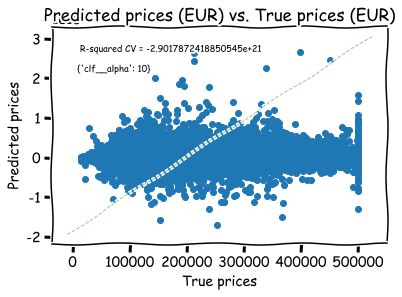

In [19]:
pipe_sgd = Pipeline([('clf', SGDRegressor())])

param_sgd = {'clf__alpha': [0.0001, 0.00001, 0.1, 1, 10]}


model(pipe_sgd, param_sgd, Xp_train, yp_train.ravel(), X, y.ravel())

### 3) Polynomial regression

In [20]:
linear_regression= LinearRegression()

##### Learning curve for LinearRegression

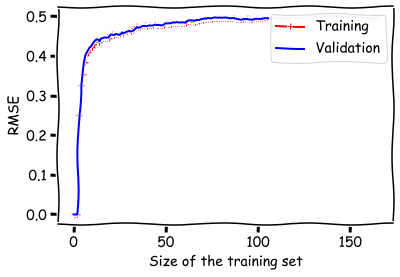

In [21]:
plot_learning_curve(linear_regression,
                    Xp_train,
                    yp_train.ravel(),
                    Xp_test,
                    yp_test.ravel(),
                    test_size=0.2,
                    step_length = 100)

#### Pipeline and Parameters for Polynomial Regression and Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................................................. , total=   0.4s
[CV]  ................................................................
[CV] ................................................. , total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.414103      0.016876         0.007672        0.001249     {}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.167385          -0.035982          -3.382406        -1.083668   

   std_test_score  rank_test_score  
0        1.627573                1  
best_index 0
best_score -1.0836677989557124
best_params {}
##### CV Results
mean_score 0.63403608138814
Model coefficients:  [(array([-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 3],
      dtype=object), array([ 1.56840155e+02, -1.27201535e+02,  2.14576425e+02, -1.37798349e+02,
        1.87094429e+02,  4.41763408e+02, -4.97777961e+02,  1.19673701e+02,
       -2.91520353e+02,  1.91841597e+02, -5.54847567e+02,  5.54276352e+02,
       -5.71968015e+02,  7.87104742e+02,  7.56317735e+02, -1.11375782e+03,
        4.36938328e+02, -1.01436140e+03, -1.61347563e+02,  1.30307015e+02,
       -2.52

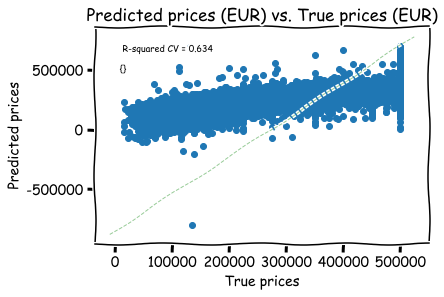

In [22]:
pipe_poly = Pipeline([('clf', LinearRegression())])

param_poly = {}


model(pipe_poly, param_poly, Xp_train, yp_train, X, y)

## 4) Ridge Regression

In [23]:
ridge_regression= Ridge()

##### Learning curve for LinearRegression

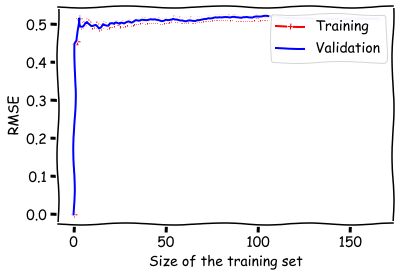

In [24]:
plot_learning_curve(ridge_regression,
                    Xp_train,
                    yp_train,
                    Xp_test,
                    yp_test,
                    test_size=0.2,
                    step_length = 100)

#### Pipeline and Parameters for Ridge and Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. clf__alpha=0.01, total=   0.3s
[CV] clf__alpha=0.01 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................. clf__alpha=0.01, total=   0.3s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.2s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.2s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.2s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.2s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.2s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.2s
[CV] clf__alpha=1 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.8s finished


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       0.218721      0.011148         0.008004        0.000814   
3       0.209385      0.031802         0.006340        0.001251   
1       0.215433      0.008115         0.006673        0.000943   
0       0.252393      0.016422         0.006670        0.000945   

  param_clf__alpha                params  split0_test_score  \
2                1     {'clf__alpha': 1}           0.723993   
3               10    {'clf__alpha': 10}           0.715760   
1              0.1   {'clf__alpha': 0.1}           0.705608   
0             0.01  {'clf__alpha': 0.01}           0.505183   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
2           0.614180           0.708240         0.682138        0.048482   
3           0.658943           0.641541         0.672081        0.031692   
1           0.438878           0.576649         0.573712        0.108912   
0           0.159482          

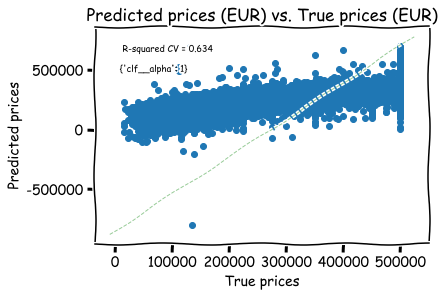

In [25]:
pipe_ridge = Pipeline([('clf', Ridge())])

param_ridge = {'clf__alpha': [0.01, 0.1, 1, 10]}


model(pipe_ridge, param_ridge, Xp_train, yp_train, X, y)


## 5) Lasso Regression

In [26]:
lasso_regression = Lasso(max_iter=1500)

##### Learning curve for Lasso

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


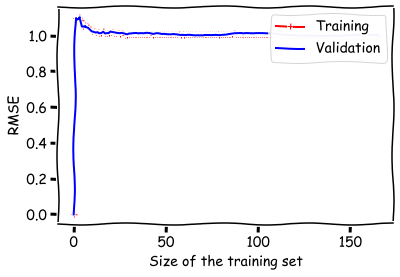

In [27]:
plot_learning_curve(lasso_regression,
                    Xp_train,
                    yp_train,
                    Xp_test,
                    yp_test,
                    test_size=0.2,
                    step_length = 100)

In [28]:
# Pipeline and Parameters - Lasso # Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.265997388348296, tolerance: 1.090219171220782
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s


[CV] .................................. clf__alpha=0.01, total=  20.3s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=  15.5s
[CV] clf__alpha=0.01 .................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.48518889980096, tolerance: 1.1177014692582325
  positive)


[CV] .................................. clf__alpha=0.01, total=  17.4s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=  11.7s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=  12.8s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   9.6s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.1s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.1s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.1s
[CV] clf__alpha=10 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.667815462299586, tolerance: 1.651200000000001
  positive)


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      17.700810      1.979409         0.006004        0.000817   
1      11.359411      1.352321         0.005000        0.000816   
2       0.120650      0.001999         0.006000        0.001413   
3       0.126661      0.006394         0.007003        0.001637   

  param_clf__alpha                params  split0_test_score  \
0             0.01  {'clf__alpha': 0.01}           0.662575   
1              0.1   {'clf__alpha': 0.1}           0.538569   
2                1     {'clf__alpha': 1}          -0.000004   
3               10    {'clf__alpha': 10}          -0.000004   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.657357           0.673298         0.664410        0.006636   
1           0.531292           0.548450         0.539437        0.007031   
2          -0.000018          -0.000040        -0.000021        0.000015   
3          -0.000018          

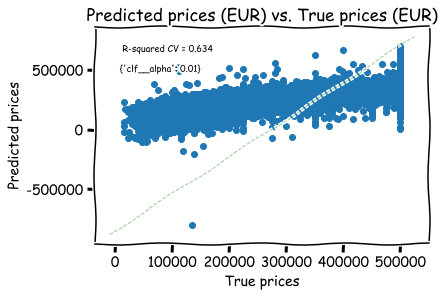

In [29]:
pipe_lasso = Pipeline([('clf', Lasso(max_iter=1500))])

param_lasso = {'clf__alpha': [0.01, 0.1, 1, 10]}


model(pipe_lasso, param_lasso, Xp_train, yp_train, X, y)


## 7) Elastic-Net Regression

In [30]:
elastic_net = ElasticNet()

##### Learning curve for ElasticNet

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


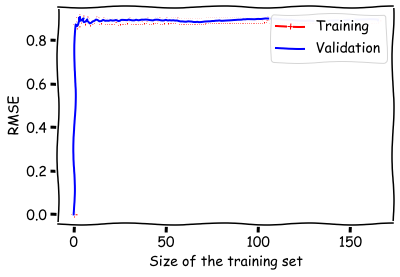

In [31]:
plot_learning_curve(elastic_net,
                    Xp_train,
                    yp_train,
                    Xp_test,
                    yp_test,
                    test_size=0.2,
                    step_length = 100)

#### Pipeline and Parameters for Lasso and Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0923393191651485, tolerance: 1.090219171220782
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s


[CV] .................................. clf__alpha=0.01, total=  14.4s
[CV] clf__alpha=0.01 .................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.948775655332156, tolerance: 1.094471912334428
  positive)


[CV] .................................. clf__alpha=0.01, total=  12.8s
[CV] clf__alpha=0.01 .................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5846057882736204, tolerance: 1.1177014692582325
  positive)


[CV] .................................. clf__alpha=0.01, total=  12.4s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   2.1s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   2.3s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   2.0s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.4s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.5s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.4s
[CV] clf__alpha=10 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   47.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.106244231344135, tolerance: 1.651200000000001
  positive)


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.175333      0.838553         0.006005        0.000001   
1       2.128516      0.137414         0.005336        0.000471   
2       0.433445      0.043186         0.006038        0.000050   
3       0.153372      0.006552         0.006363        0.000452   

  param_clf__alpha                params  split0_test_score  \
0             0.01  {'clf__alpha': 0.01}           0.674888   
1              0.1   {'clf__alpha': 0.1}           0.566657   
2                1     {'clf__alpha': 1}           0.202653   
3               10    {'clf__alpha': 10}          -0.000004   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.671335           0.683238         0.676487        0.004989   
1           0.560999           0.579481         0.569046        0.007732   
2           0.205116           0.214034         0.207268        0.004889   
3          -0.000018          

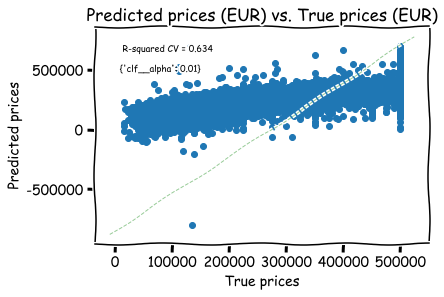

In [32]:
pipe_elasticnet = Pipeline([('clf', ElasticNet())])

param_lasso = {'clf__alpha': [0.01, 0.1, 1, 10]}


model(pipe_elasticnet, param_lasso, Xp_train, yp_train, X, y)


## Using California Housing Dataset in Scikit-learn

Also scikit-learn comes with wide variety of datasets for regression, classification and other problems. Lets load our data into pandas dataframe and take a look.
In this part We will work with the California housing dataset in sklearn and perform some different models to predict apartment `prices` based on the ``median income`` in the block.

#### Load the dataset

In [33]:
from sklearn.datasets import california_housing

housing_data = california_housing.fetch_california_housing()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.california_housing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [34]:
Features = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
Target = pd.DataFrame(housing_data.target, columns=['Target'])
df = Features.join(Target)

Features as `MedInc` and `Target` were scaled to some degree.

In [35]:
df.corr()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc      1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge   -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms    0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms  -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population  0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup    0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
Latitude   -0.079809  0.011173  0.106389   0.069721   -0.108785  0.002366   
Longitude  -0.015176 -0.108197 -0.027540   0.013344    0.099773  0.002476   
Target      0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

            Latitude  Longitude    Target  
MedInc     -0.079809  -0.015176  0.688075  
HouseAge    0.011173  -0.108197  0.105623  
AveRooms    0.106389  -0.027540  0.151948  
AveBedrms   0.069721   0.013344 -0.046701  
Population -0.108785   0.099773 -0.024650  
AveOccup    0.002366   0.002476 -0.023737  
Latitude    1.000000  -0.924664 -0.144160  
Longitude  -0.924664   1.000000 -0.045967  
Target     -0.144160  -0.045967  1.000000

## Preprocessing: Removing Outliers and Scaling

In [36]:
df[['MedInc', 'Target']].describe()[1:] #.style.highlight_max(axis=0)

MedInc    Target
mean   3.870671  2.068558
std    1.899822  1.153956
min    0.499900  0.149990
25%    2.563400  1.196000
50%    3.534800  1.797000
75%    4.743250  2.647250
max   15.000100  5.000010

It seems that `Target` has some outliers (as well as `MedInc`), because 75% of the data has price less than 2.65, but maximum price go as high as 5. We're going to remove extremely expensive houses as they will add unnecessary noize to the data.

In [37]:
df = df[df.Target < 3.5]
df = df[df.MedInc < 8]

### Removed Outliers

In [38]:
df[['MedInc', 'Target']].describe()[1:]

MedInc    Target
mean  3.482030  1.722805
std   1.364922  0.749957
min   0.499900  0.149990
25%   2.452025  1.119000
50%   3.303600  1.635000
75%   4.346050  2.256000
max   7.988700  3.499000

We will also scale `MedInc` and `Target` variables to [0-1].

In [39]:
sc = MinMaxScaler()
mid_income = sc.fit_transform(df['MedInc'].values.reshape(df.shape[0],1))
target = sc.fit_transform(df['Target'].values.reshape(df.shape[0],1))

In [40]:
mid_income.max(), target.max()

(1.0, 1.0)

## Correlation Between Price and Income

Visually we can determine what kind of accuracy we can expect from the models.

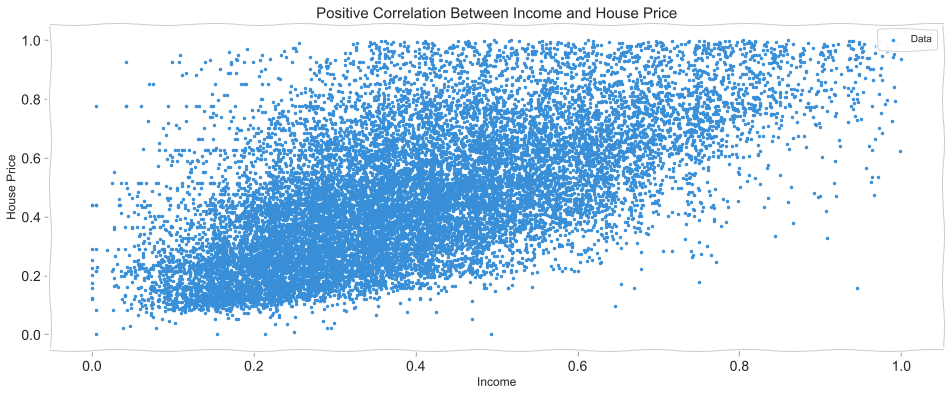

In [41]:
plt.figure(figsize=(16,6))
plt.rcParams['figure.dpi'] = 227
plt.style.use('seaborn-whitegrid')
plt.scatter(mid_income, target, label='Data', c='#388fd8', s=6)
plt.title('Positive Correlation Between Income and House Price', fontSize=15)
plt.xlabel('Income', fontSize=12)
plt.ylabel('House Price', fontSize=12)
plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
plt.show()

In [42]:
def plot_regression(X,  y, X_test, y_pred, title, log=None):
    plt.xkcd()
    plt.figure(figsize=(16,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.35)
    plt.plot(X_test, y_pred, c='#ff7702', lw=3, label='Regression')
    plt.title(title, fontSize=14)
    plt.xlabel('Income', fontSize=11)
    plt.ylabel('Price', fontSize=11)
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(mid_income, target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

## K-Nearest Neighbors

In [44]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

MSE: 0.03498385179277483


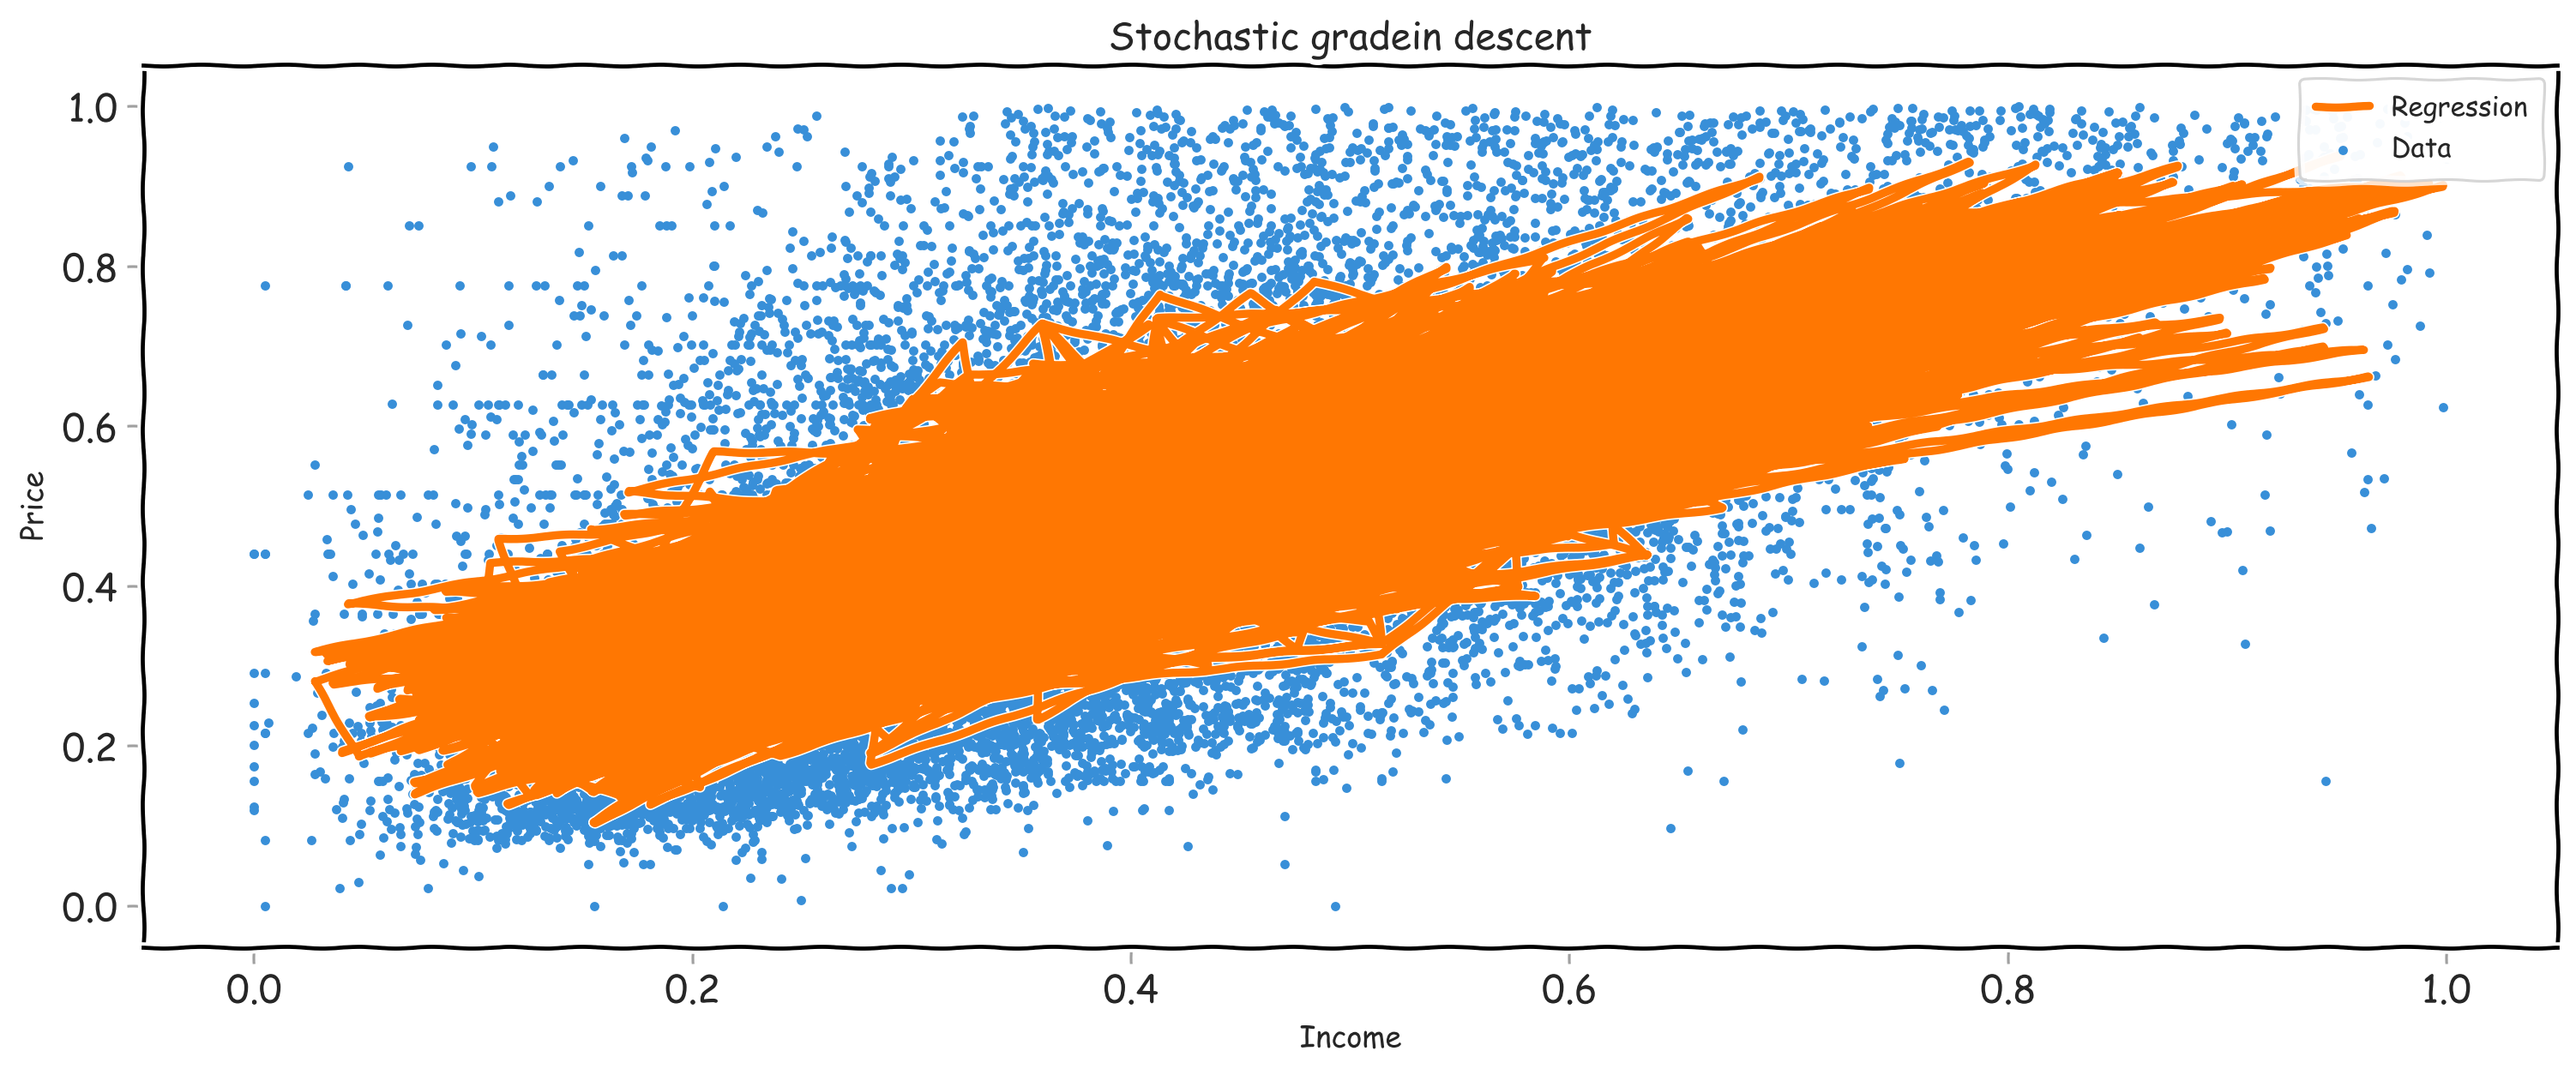

In [45]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression(mid_income, target, X_test, y_pred, title="Stochastic gradein descent")

## Stochastic gradient descent 

In [46]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE: 0.029399742393360663


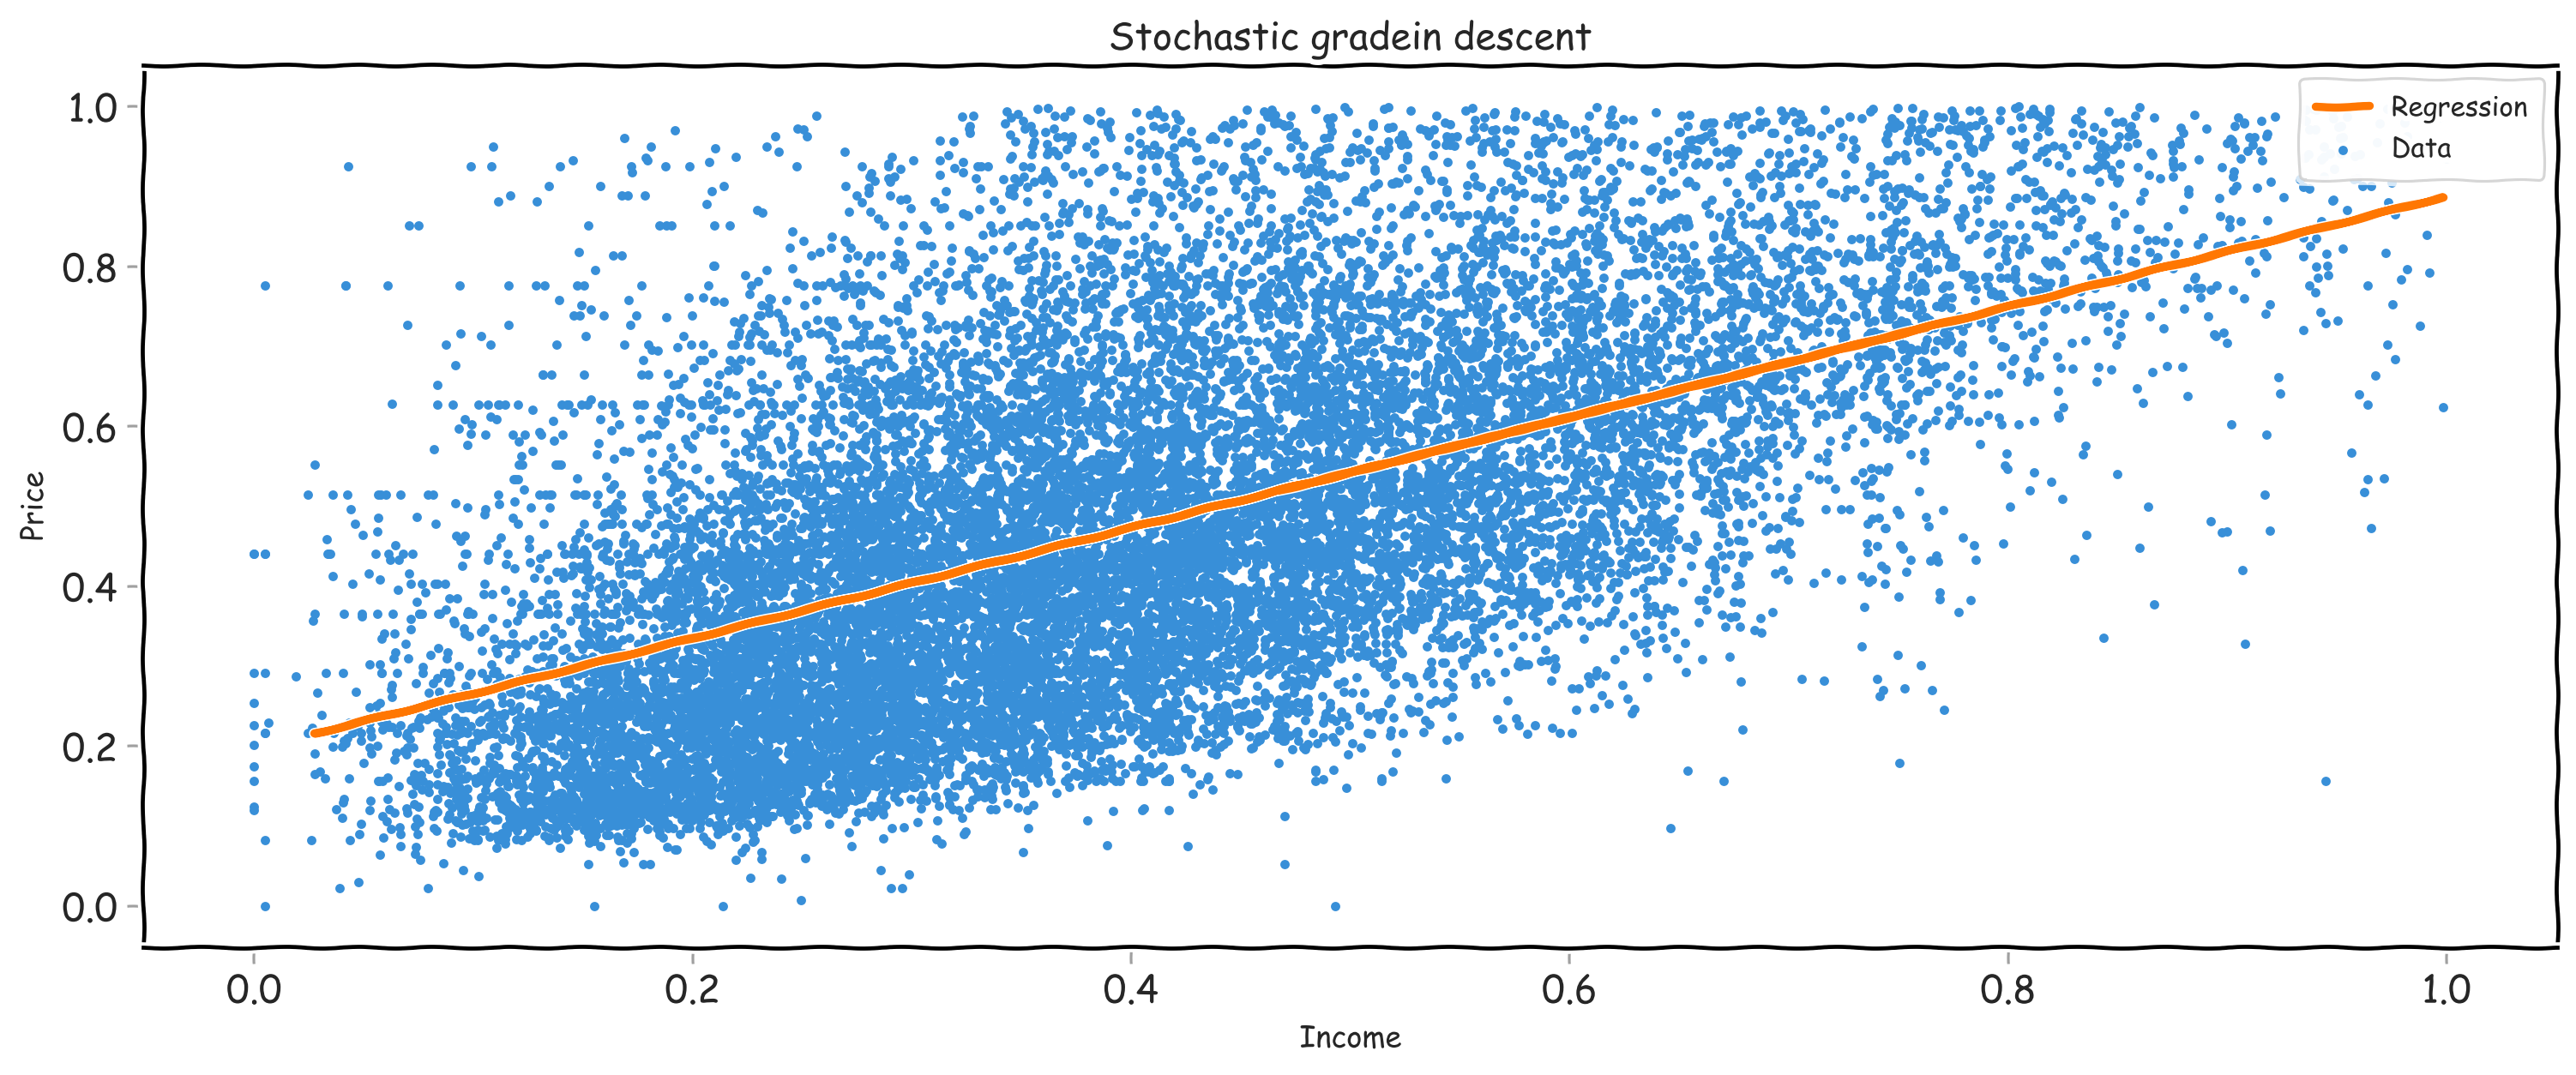

In [47]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression(mid_income, target, X_test, y_pred, title="Stochastic gradein descent")

## Linear Regression 

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

MSE: 0.029100054710772153


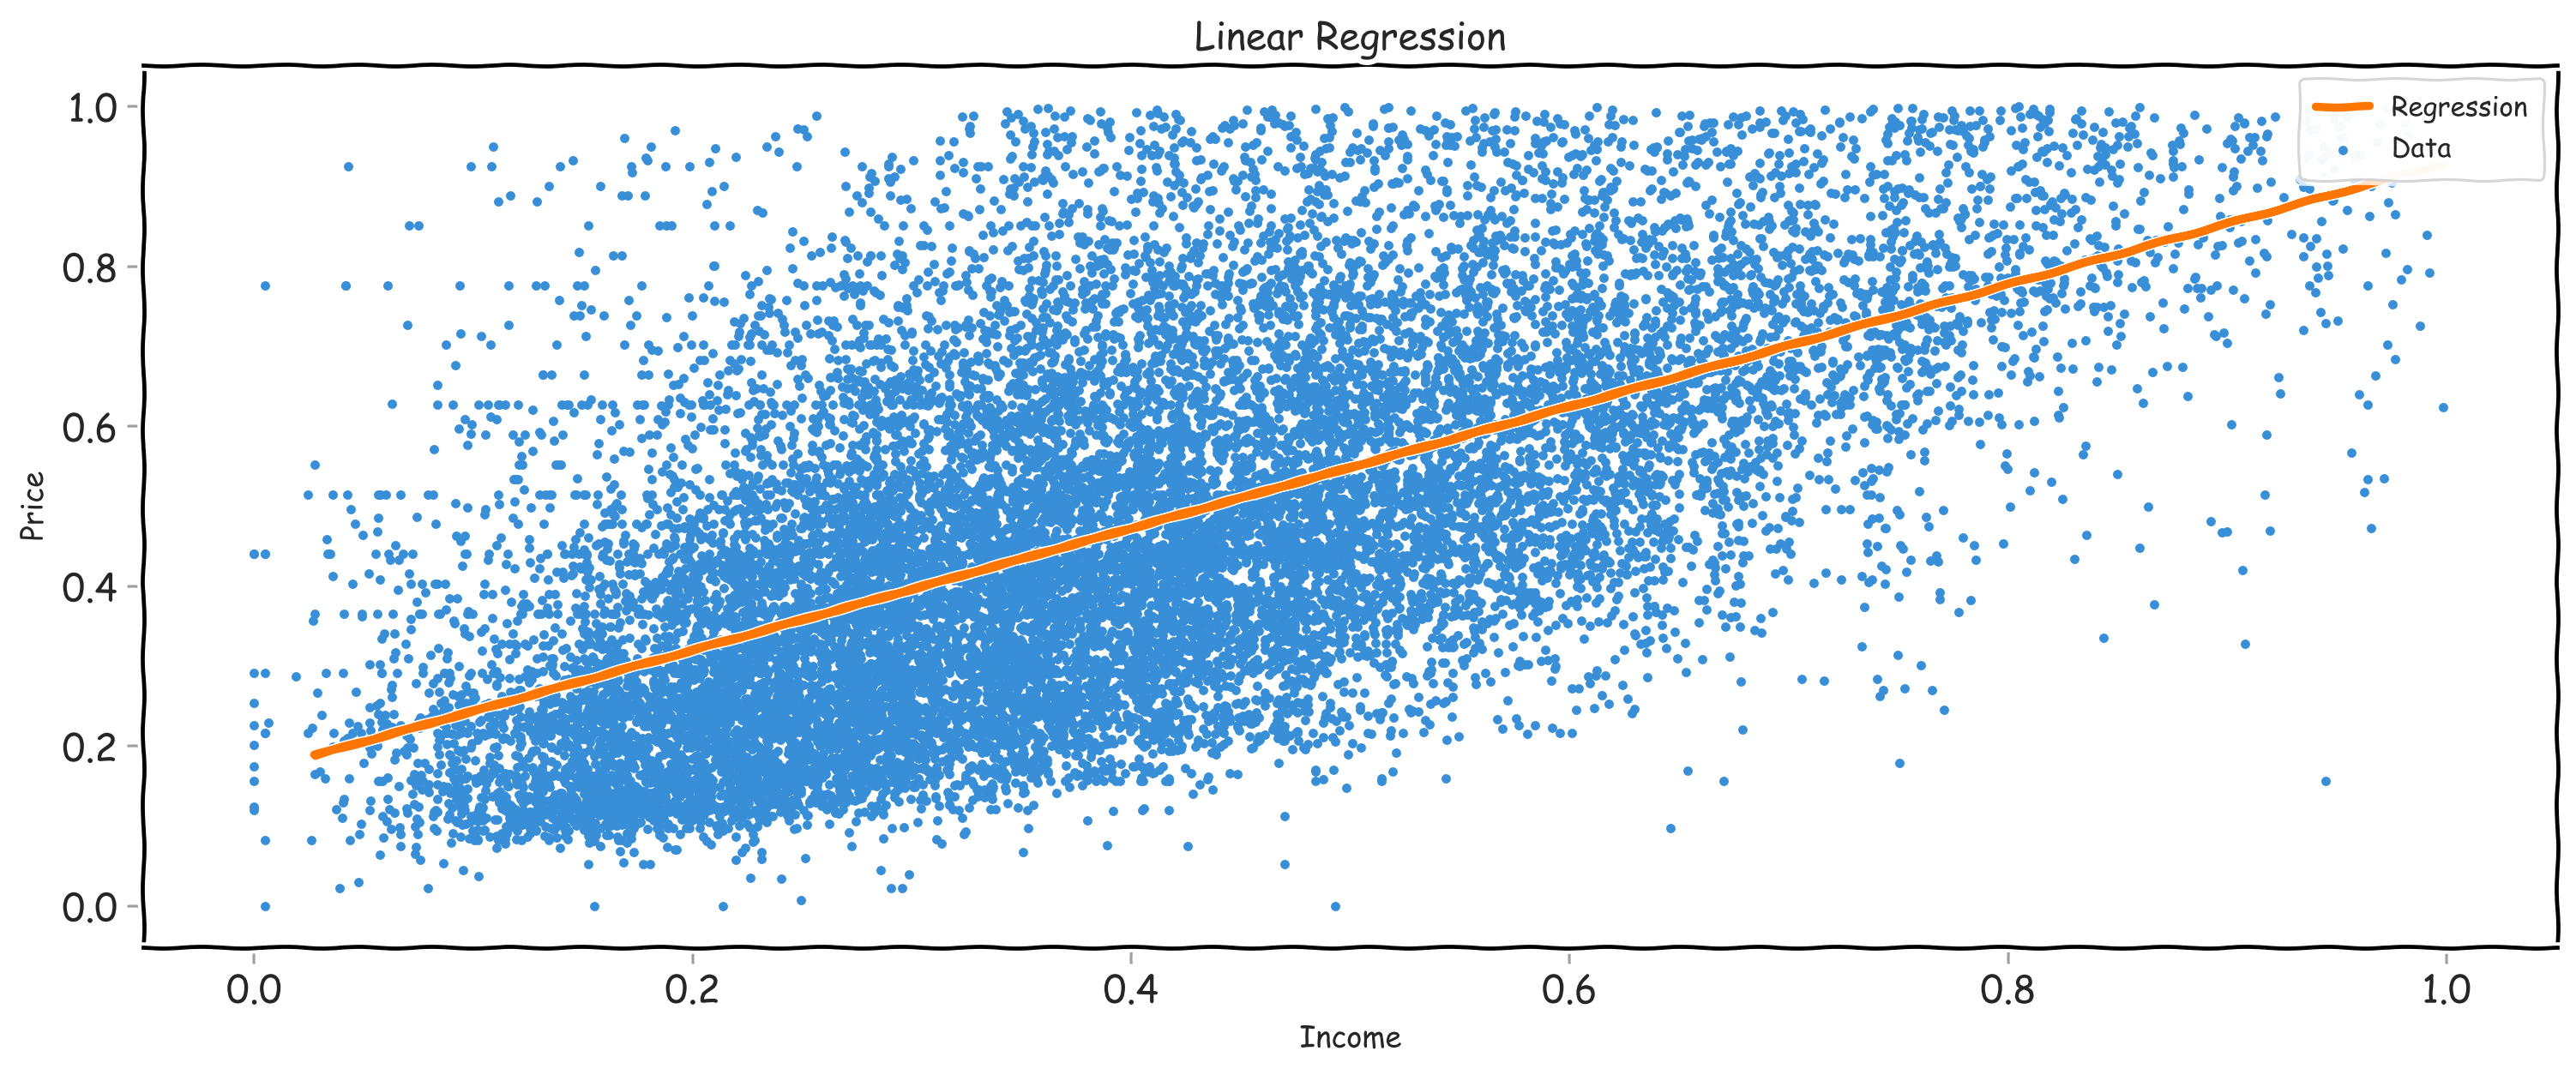

In [49]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression(mid_income, target, X_test, y_pred, title="Linear Regression")

Result of our model is the regression line. Just by looking at the graph we can tell that data points go well above and beyond our line, making predictions approximate.

## Ridge Regression 

In [50]:
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

MSE: 0.029102726096384174


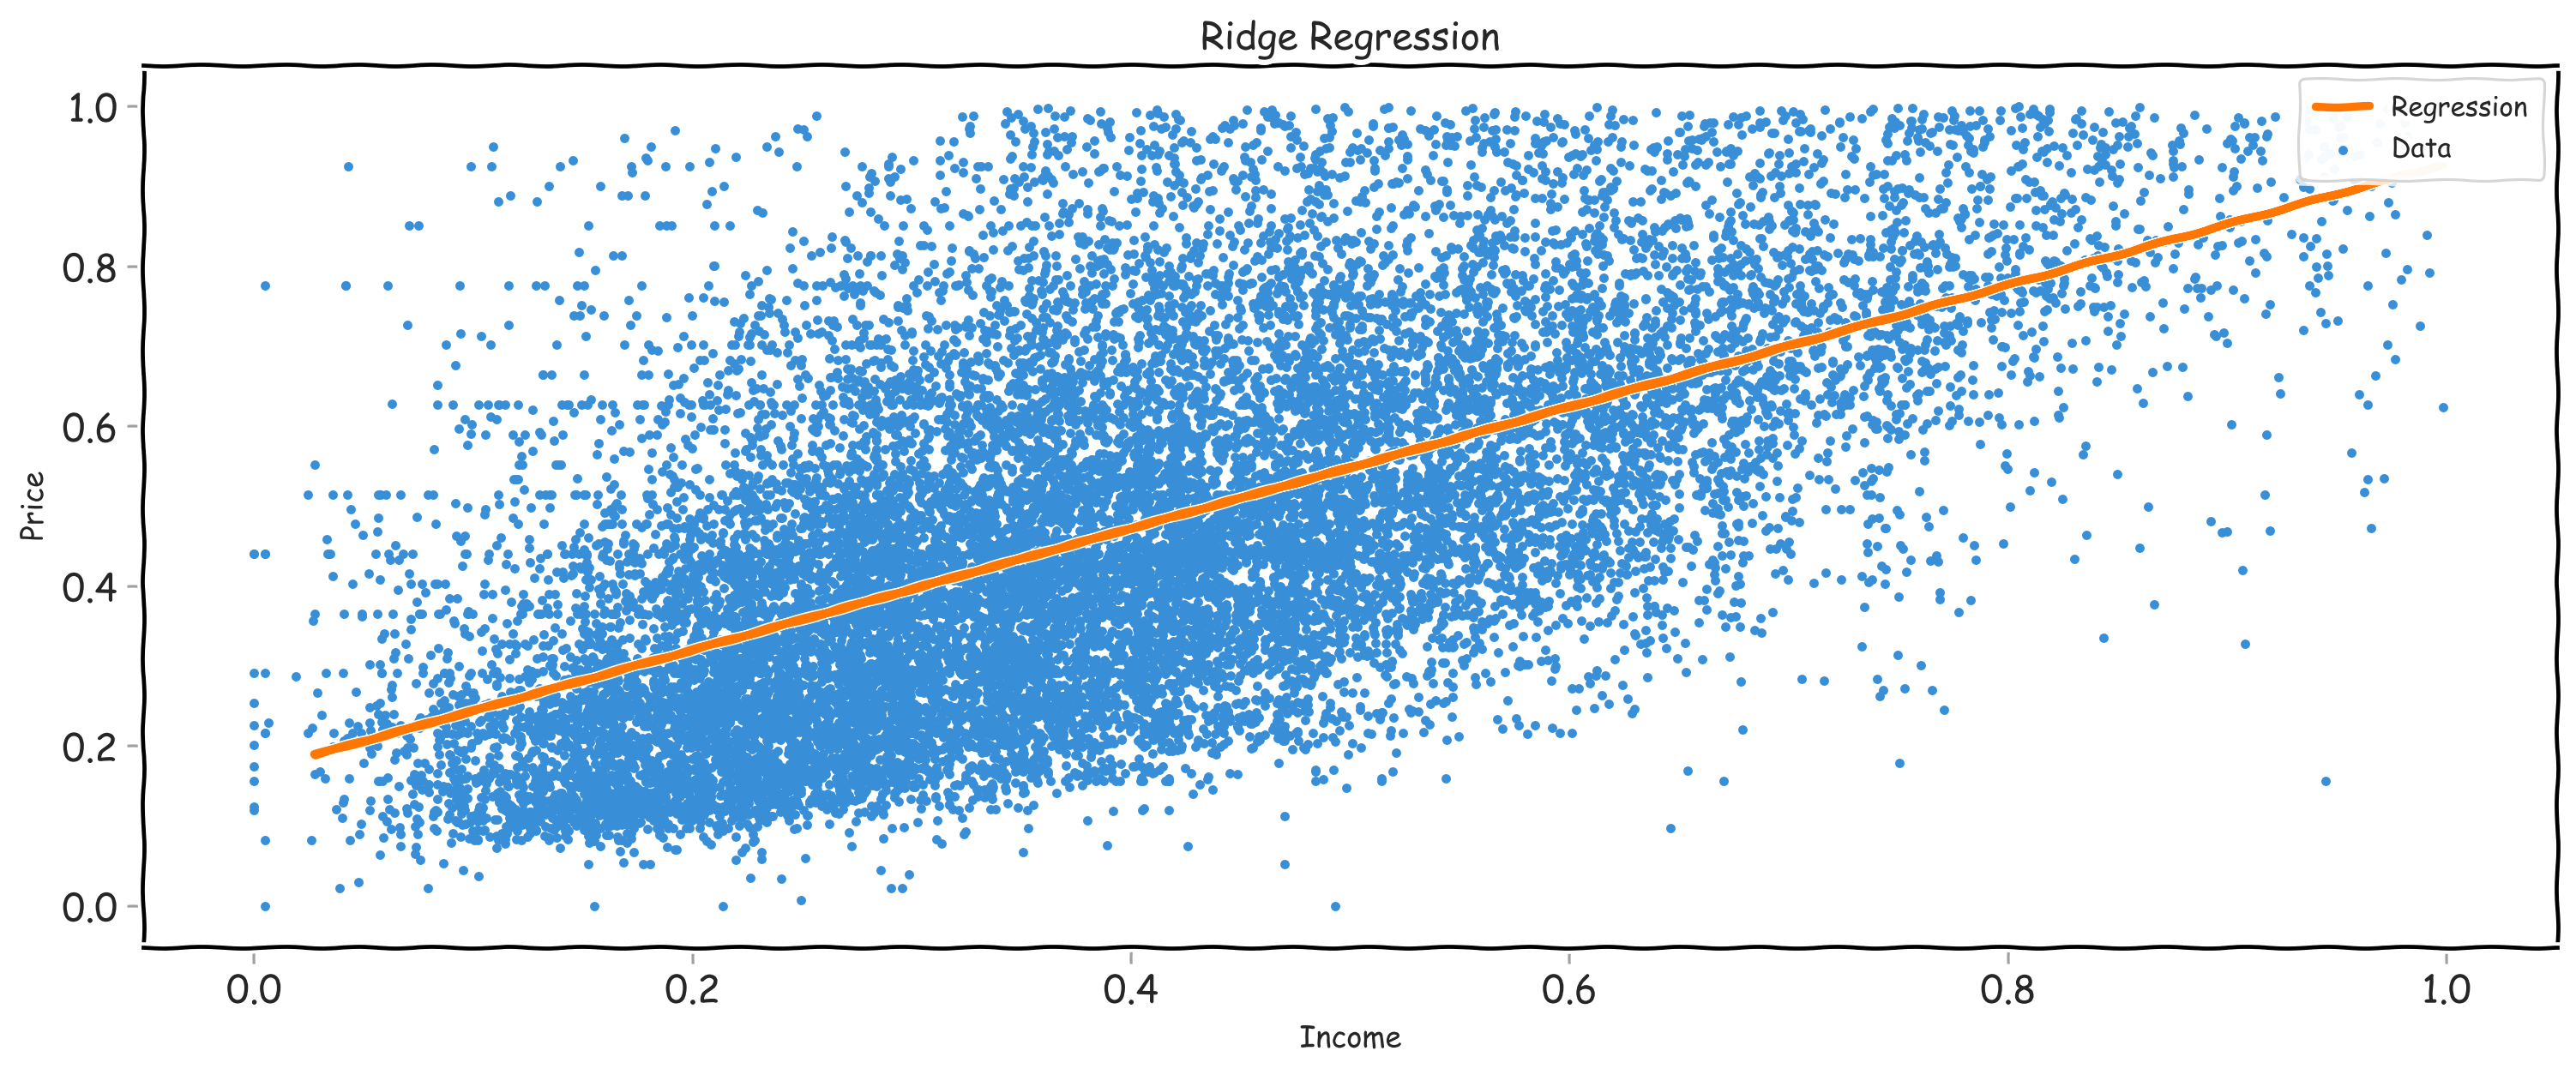

In [51]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression( mid_income, target, X_test, y_pred, title="Ridge Regression")

## LASSO Regression 

In [52]:
lasso = Lasso()

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

MSE: 0.05016558027920586


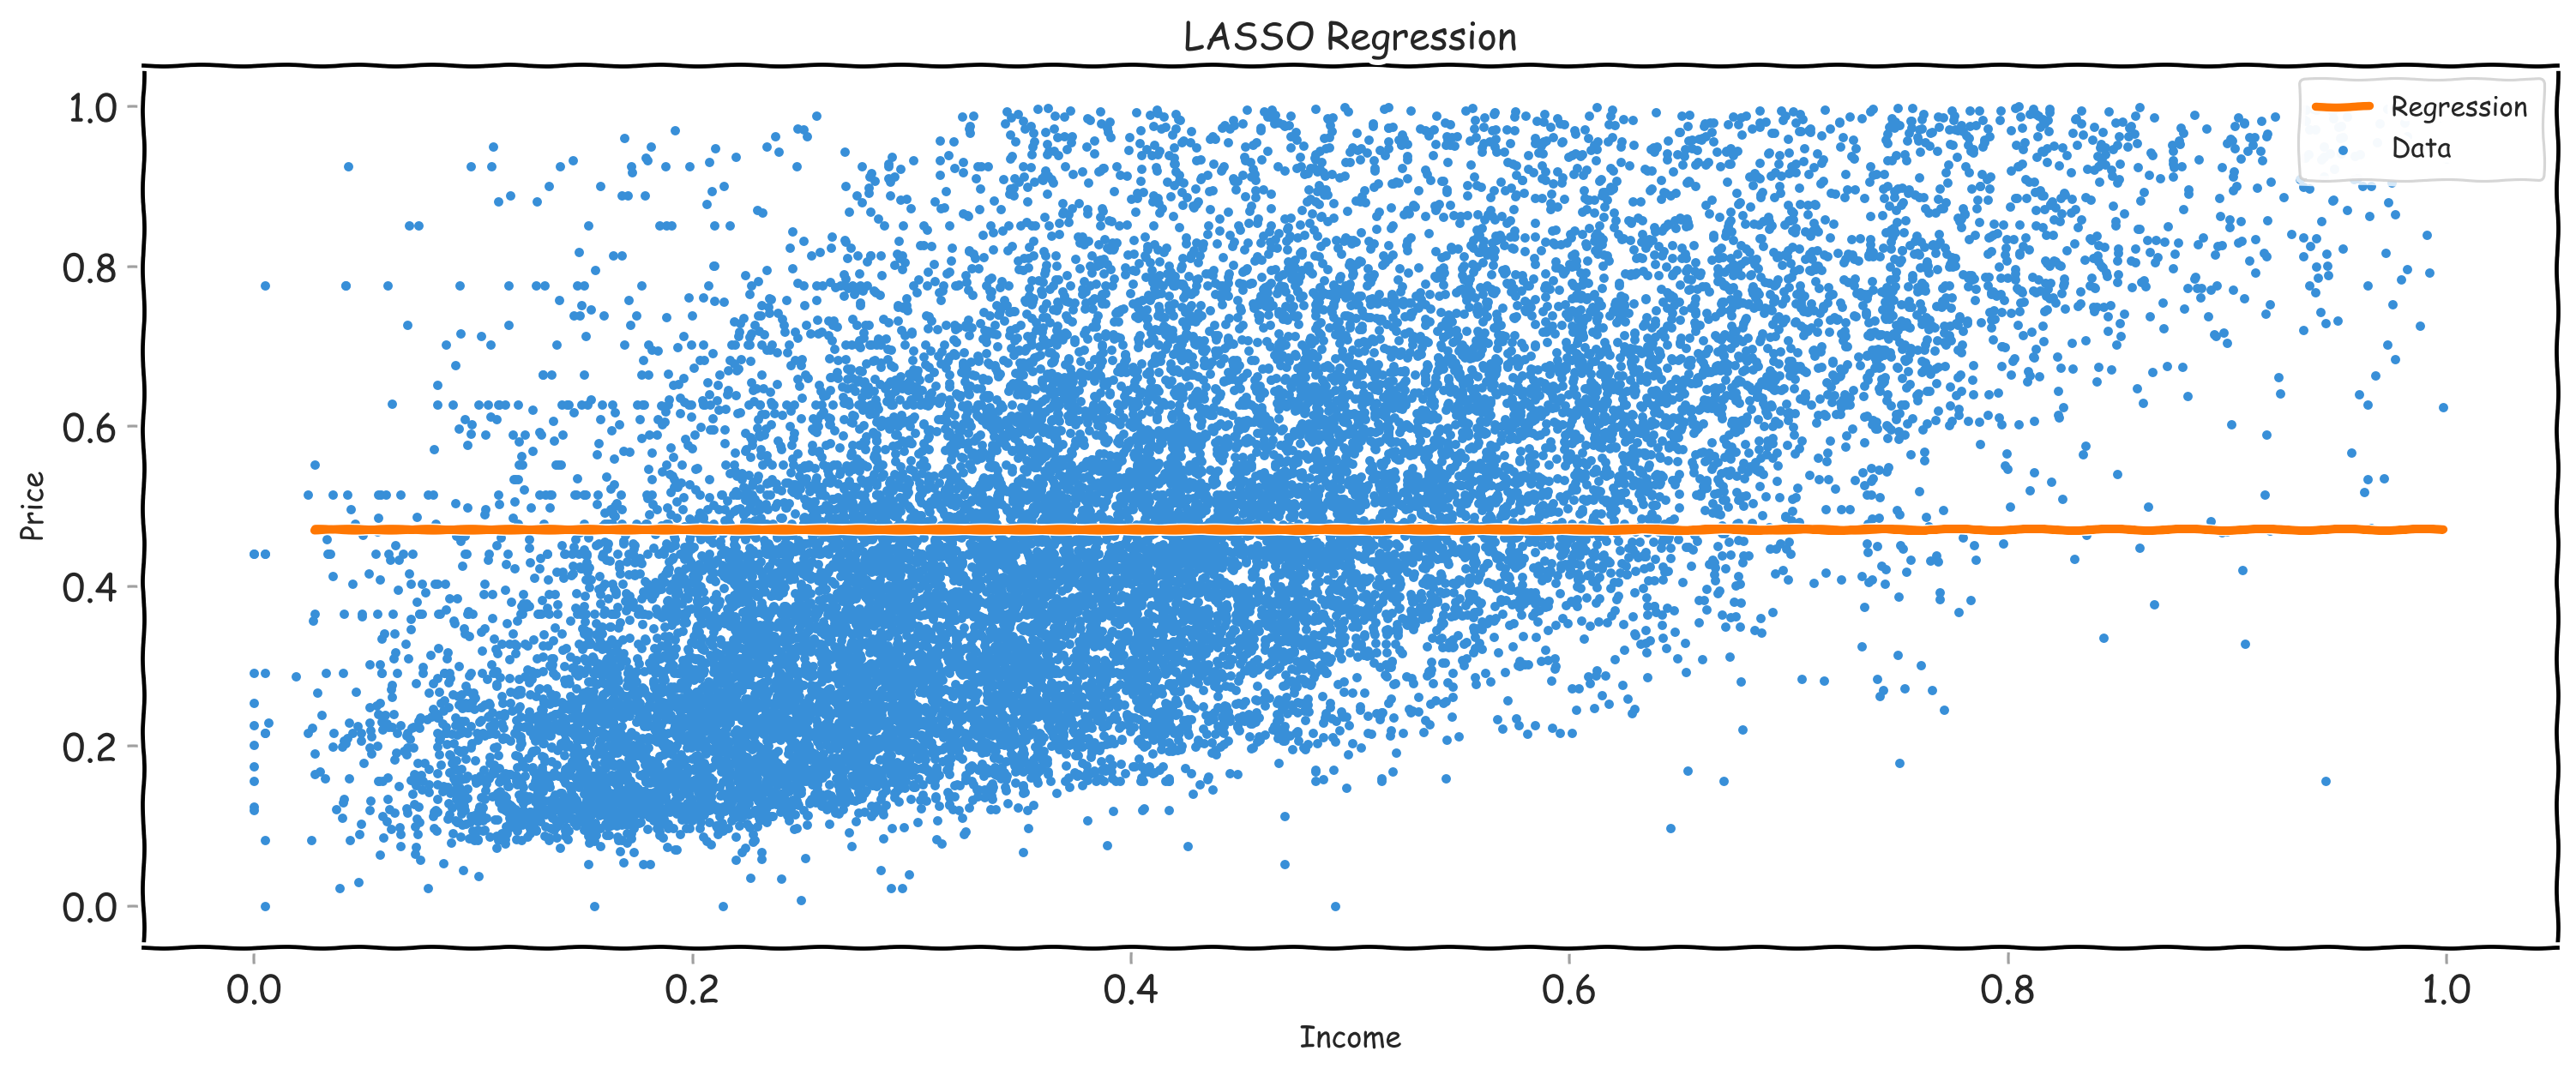

In [53]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression( mid_income, target, X_test, y_pred, title="LASSO Regression")

## ElasticNet Regression

In [54]:
elastic_net = ElasticNet()

elastic_net.fit(X_train, y_train)
y_pred = elastic_net.predict(X_test)

MSE: 0.05016558027920586


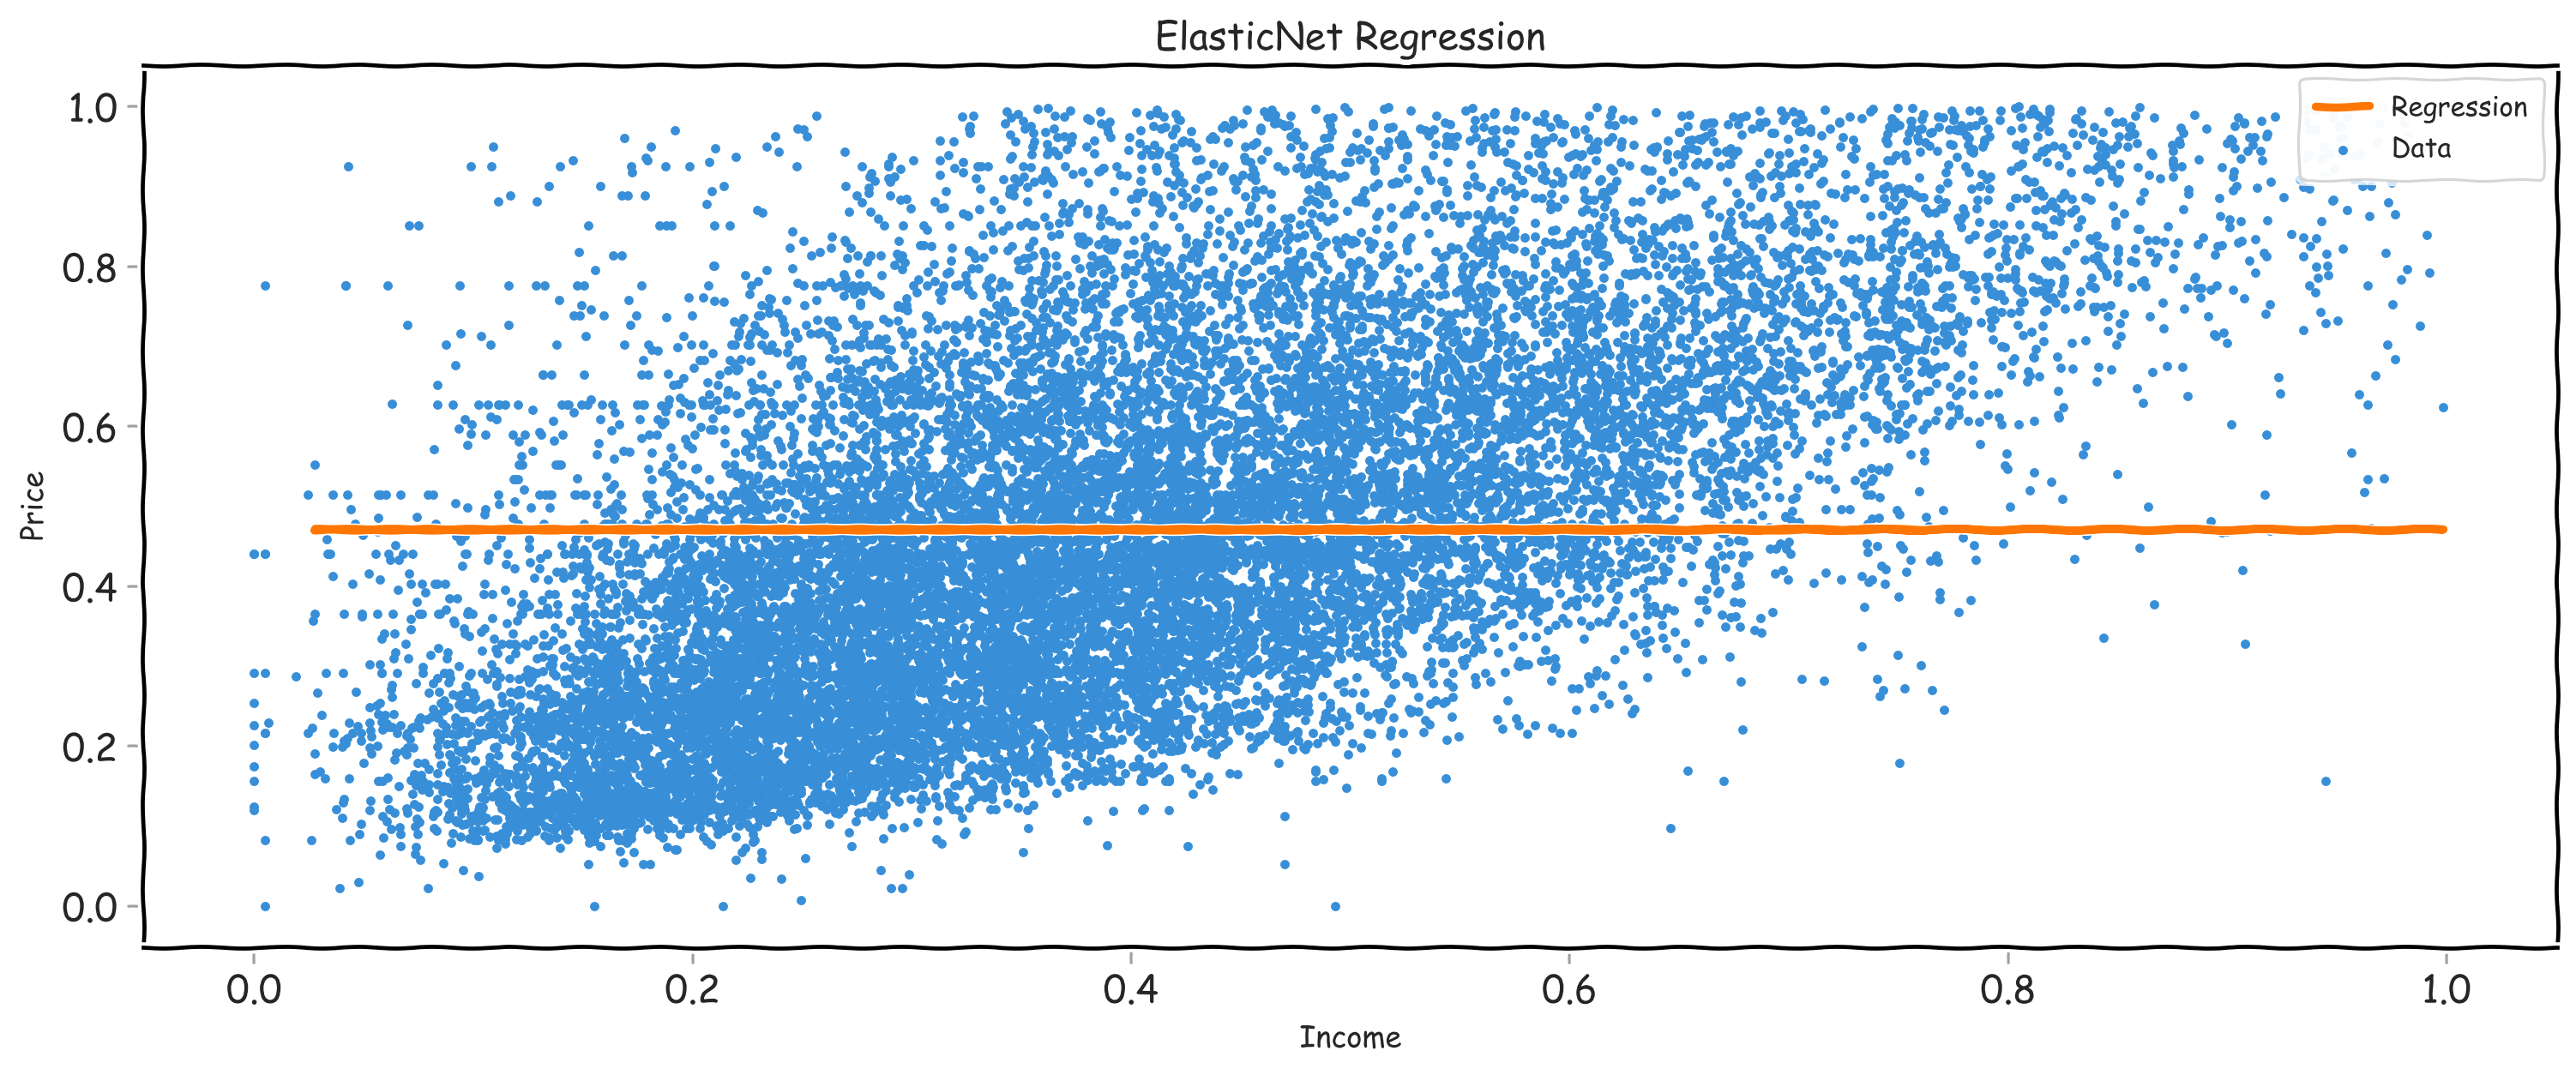

In [55]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression( mid_income, target, X_test, y_pred, title="ElasticNet Regression")

In [60]:
scores = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'F1-score': f1_score
}
for name, scorer in scores.items():
    print(f'The {name} of Bernoulli Naive Bayes is {scorer(y_test, y_pred)}')

ValueError: continuous is not supported

In [64]:
regr = svm.SVR()
regr.fit(X_train, y_train.ravel())
y_pred = regr.predict(X_test)

MSE: 0.028958544237046597


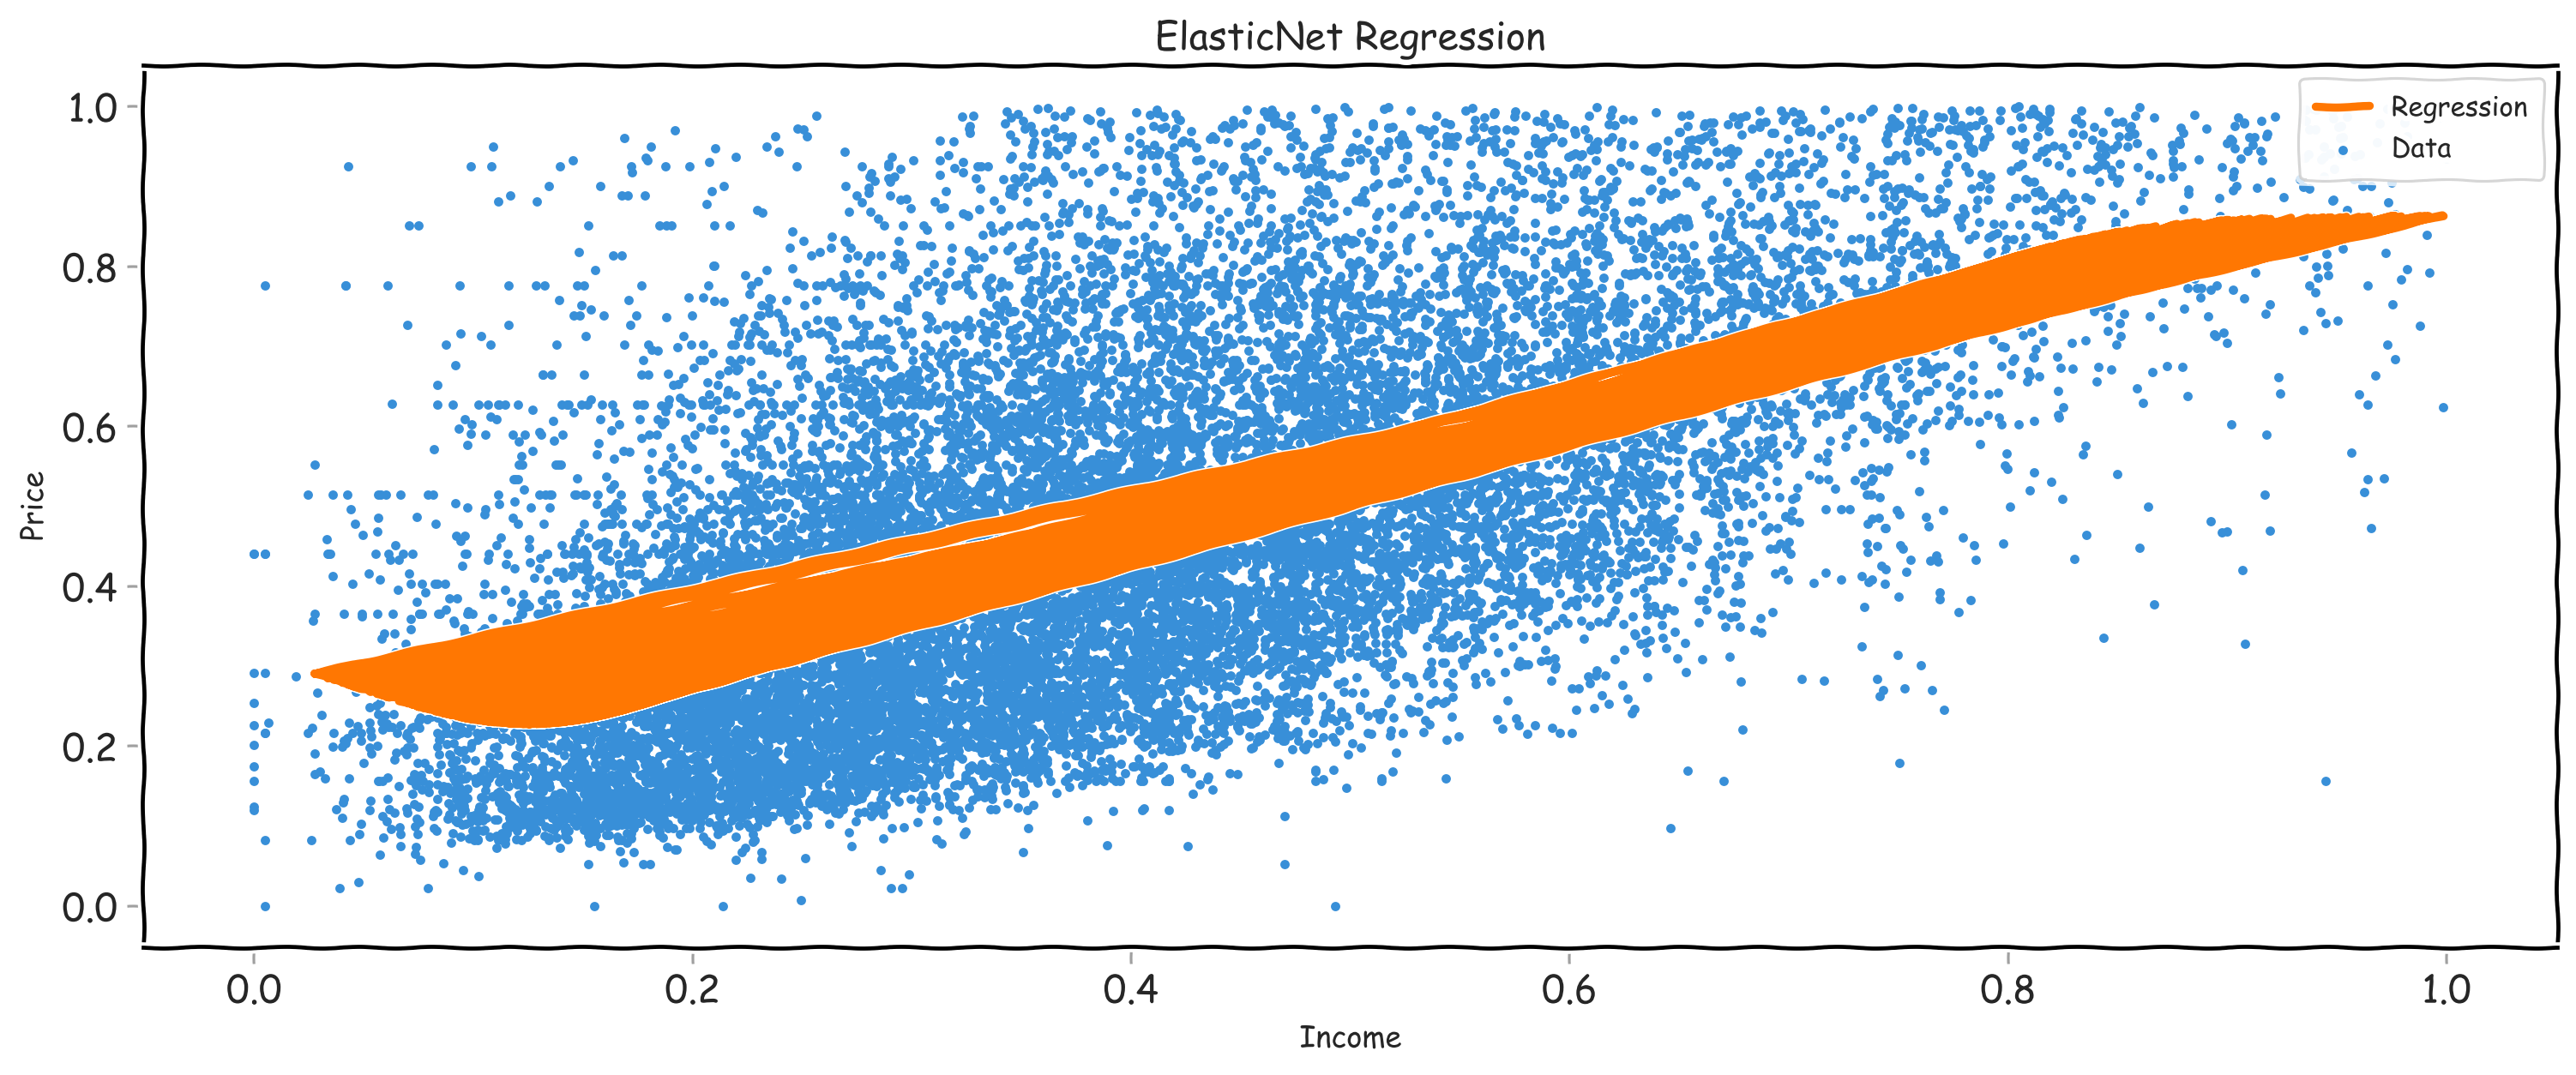

In [65]:
print("MSE:",mean_squared_error(y_test, y_pred))
plot_regression( mid_income, target, X_test, y_pred, title="ElasticNet Regression")